In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch


In [2]:
# We have already computed the bulk using the compute bulk script, so now only need to load 
psd = xr.load_dataset('../../data/processed/psd.nc')


Training samples: 7528
Validating samples: 879
Testing samples: 1666


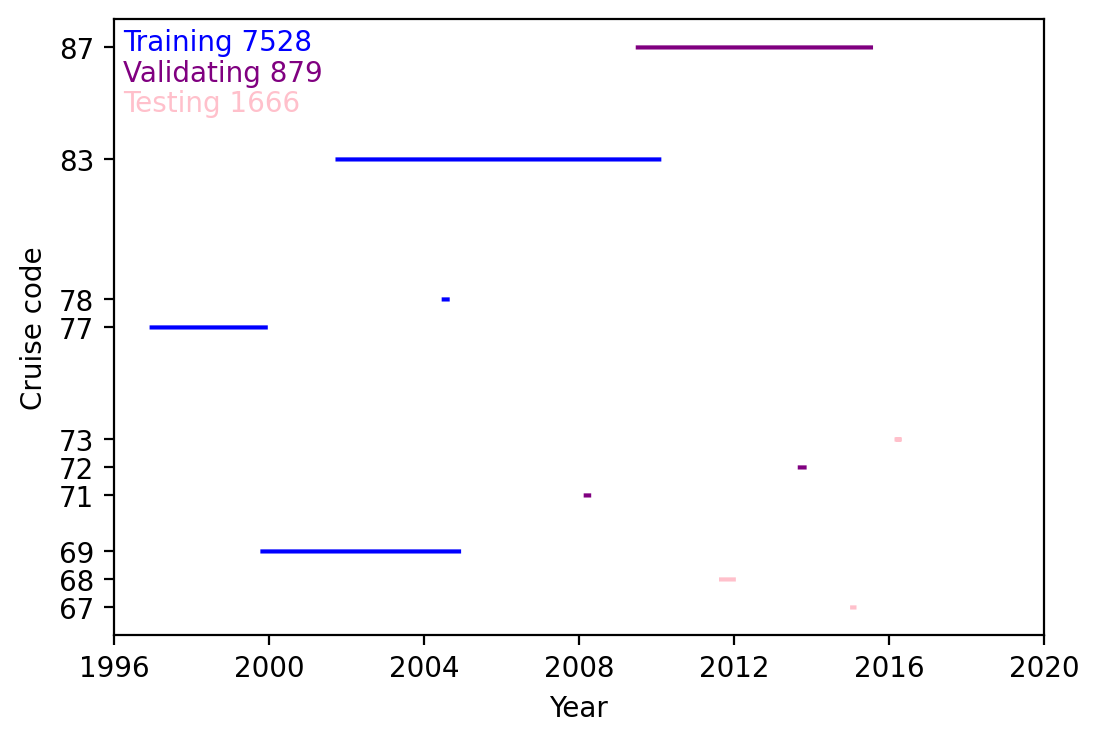

In [3]:
from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset, sample_weights

training_ds, validating_ds, testing_ds = data_split_psd(psd, split=[[77, 69, 83, 78], [87, 72, 71], [68, 67, 73]],
                                    PLOT=True, XVIS='time', )


In [5]:
class Flux11(FluxANNs):
    @cached_property
    def Xscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([20]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([1.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        x1_vis = np.linspace(0,20,100)
        X_uniform = np.hstack([x1_vis.reshape(-1,1),])
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        # REMEMBER the pred_var function already squared var_net outputs
        return (self.pred_mean(X_uniform).detach(), self.pred_var(X_uniform).detach())

In [29]:
from mlflux.ann import ANN
import torch.nn as nn
class ANNdiff(ANN):
    def __init__(self, n_in=3, n_out=1, hidden_channels=[24, 24], degree=None):
        
        self.degree = degree # But not necessary for this application
    
        layers = []
        fixed_layer = nn.Linear(n_in, n_in+1, bias=False)
        weights = torch.tensor([[1,0,0],[0,1,0],[0,0,1],[0,1,-1]]) # The additional variable takes the difference of the temperature
        fixed_layer.weight = nn.Parameter(weights,requires_grad=False)
        layers.append(fixed_layer) # Only works when inputs are U-Tsea-Tair
        layers.append(nn.Linear(n_in+1, hidden_channels[0]))
        layers.append(nn.Sigmoid())
        
        for i in range(len(hidden_channels)-1):
            layers.append(nn.Linear(hidden_channels[i], hidden_channels[i+1]))
            layers.append(nn.Sigmoid())
            
        layers.append(nn.Linear(hidden_channels[-1], n_out))
        
        self.layers = nn.Sequential(*layers)

class Flux21(FluxANNs):
    
    def __init__(self, params={}):
        super().__init__(params)
        # Check that it has all the parameters
        if not hasattr(self, "mean_ann_para"):
            raise ValueError('Need to define ANN parameters for mean!')
        if not hasattr(self, "var_ann_para"):
            raise ValueError('Need to define ANN parameters for var!')
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,1]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2
        scale = torch.tensor(np.array([20,1]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([-8]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([20.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
        x1_mesh, x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')
        X_uniform = np.hstack([x1_mesh.reshape(-1,1), x2_mesh.reshape(-1,1)])
        X_uniform = torch.tensor(X_uniform.astype('float32'))
        mean_uniform = self.pred_mean(X_uniform).detach().reshape(100,100)
        var_uniform = self.pred_var(X_uniform).detach().reshape(100,100)
        return (mean_uniform, var_uniform)

In [18]:
''' 2D input (wind speed, temp difference) - 1D output (heat flux)
'''

# Right now do it like this
from torch.utils.data import Dataset
class RealFluxDatasetVar(Dataset):
    def __init__(self, ds, input_keys=['U','tsea','tair','rh'], output_keys=['taucx','hsc','hlc'], 
                 weightfunc=sample_weights):
        
        # Assemble input and output features
        self.X = torch.tensor(np.hstack([ds['U'].values.reshape(-1,1),
                                         (ds['tsea']-ds['tair']).values.reshape(-1,1)]).astype('float32'))
        self.Y = torch.tensor(np.hstack([ds['hsc'].values.reshape(-1,1),]).astype('float32'))
            
        # Weights according to weightfunc of choice
        # TODO: only depends on wind. How to write this better?
        self.W = torch.tensor(weightfunc(self.X[:,0]).astype('float32'))
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.W[idx]

# Initiate the Dataset class and use default weighting
para1 = {'n_in':2,'n_out':1,'hidden_channels':[16]}
para2 = {'n_in':2,'n_out':1,'hidden_channels':[16]}
model = Flux21({'mean_ann_para':para1, 'var_ann_para':para2})

training_data = RealFluxDatasetVar(training_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)
validating_data = RealFluxDatasetVar(validating_ds, input_keys=['U','tsea','tair'], output_keys=['hsc'],
                                weightfunc=sample_weights)




In [19]:
training_paras = {'batchsize':100, 'num_epochs':200, 'lr':5e-3, 'gamma':0.2}
log, training_data_cp = model.fit(training_data,validating_data,training_paras)

Epoch [1/200], Loss: 17332.35019587
Epoch [2/200], Loss: 7938.52435053
Epoch [3/200], Loss: 6183.18064266
Epoch [4/200], Loss: 5964.86563361
Epoch [5/200], Loss: 6569.35070007
Epoch [6/200], Loss: 6631.48343253
Epoch [7/200], Loss: 5170.15067523
Epoch [8/200], Loss: 5916.18128813
Epoch [9/200], Loss: 5909.97812976
Epoch [10/200], Loss: 6218.52884508
Epoch [11/200], Loss: 4230.17772073
Epoch [12/200], Loss: 7871.89676351
Epoch [13/200], Loss: 4941.29102103
Epoch [14/200], Loss: 6787.79697425
Epoch [15/200], Loss: 5347.71812057
Epoch [16/200], Loss: 6320.77370914
Epoch [17/200], Loss: 4527.39695061
Epoch [18/200], Loss: 5299.45683890
Epoch [19/200], Loss: 4939.38243498
Epoch [20/200], Loss: 5400.29272073
Epoch [21/200], Loss: 4766.52417443
Epoch [22/200], Loss: 5240.20433159
Epoch [23/200], Loss: 4185.62347787
Epoch [24/200], Loss: 4649.07965138
Epoch [25/200], Loss: 4432.70296594
Epoch [26/200], Loss: 5234.12408008
Epoch [27/200], Loss: 4894.71035404
Epoch [28/200], Loss: 3508.82777085


In [31]:
training_data.X[:,1].mean()

tensor(1.0491)

(0.0, 1.0)

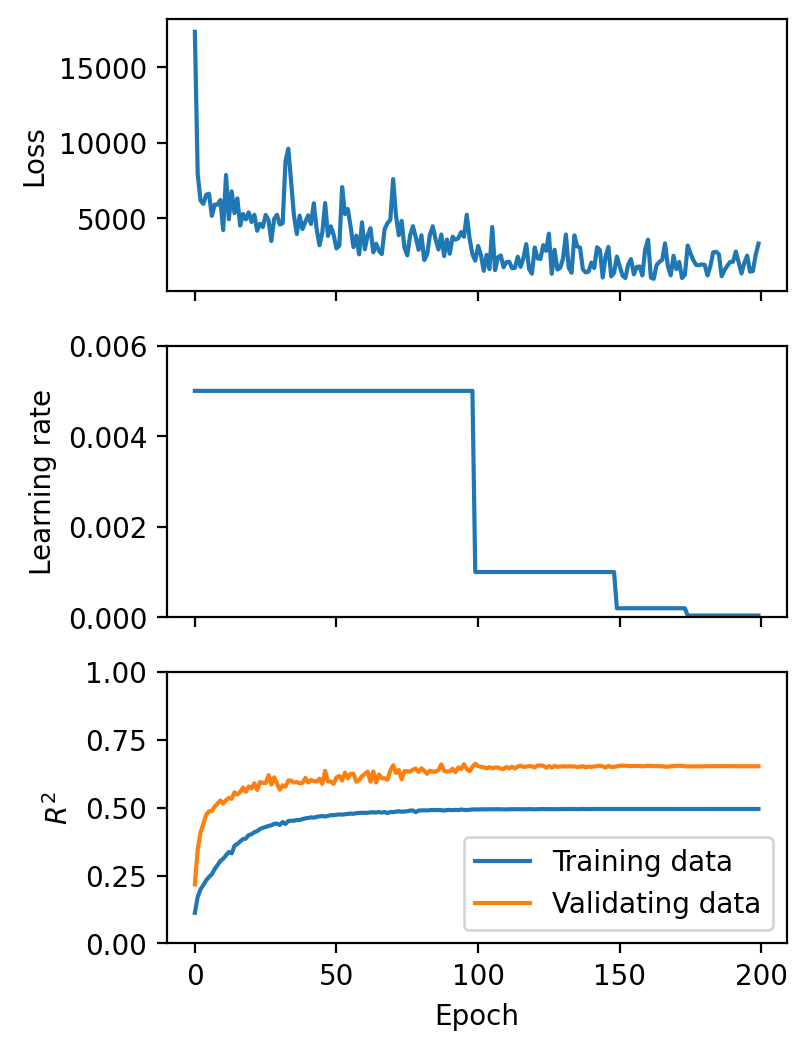

In [20]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
# axes[0].set_ylim([-400,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])
axes[2].plot(log['training_score'], label='Training data')
axes[2].plot(log['validating_score'], label='Validating data')
axes[2].set_ylabel(r'$R^2$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].set_ylim([0,1])

Text(0, 0.5, 'Sensible heat flux')

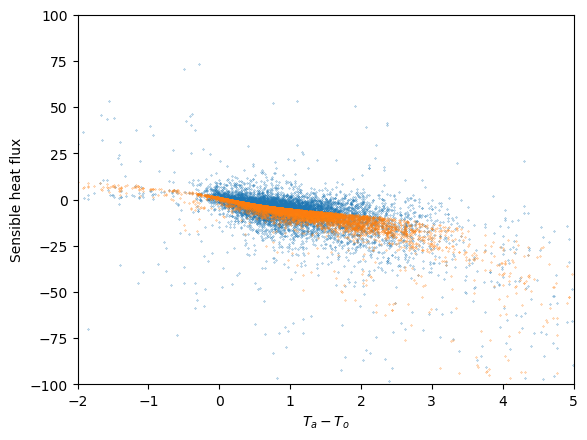

In [21]:
plt.plot(training_data.X[:,1],training_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(training_data.X)
plt.plot(training_data.X[:,1],Y_pred.detach(), '.', markersize=0.5)
ax = plt.gca()
ax.set_ylim([-100,100]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_a-T_o$'); ax.set_ylabel('Sensible heat flux')


Text(0, 0.5, 'Sensible heat flux')

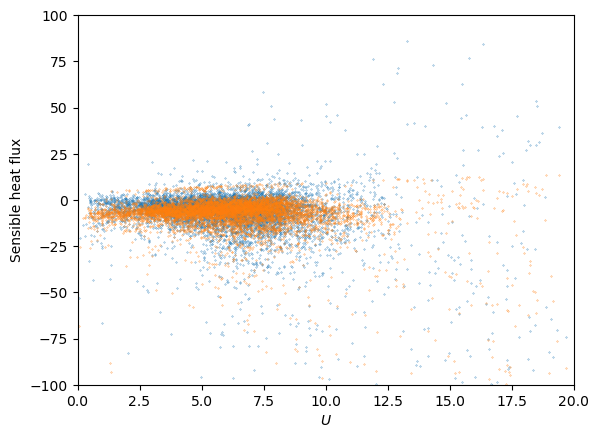

In [22]:
plt.plot(training_data.X[:,0],training_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(training_data.X)
plt.plot(training_data.X[:,0],Y_pred.detach(), '.', markersize=0.5)
ax = plt.gca()
ax.set_ylim([-100,100]); ax.set_xlim([0,20])
ax.set_xlabel('$U$'); ax.set_ylabel('Sensible heat flux')

Text(0, 0.5, 'Sensible heat flux')

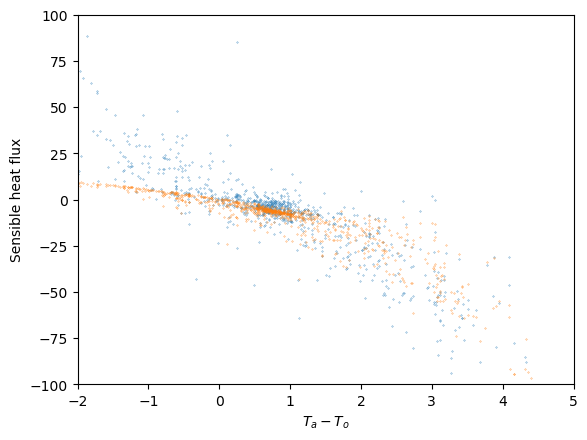

In [16]:
plt.plot(validating_data.X[:,1],validating_data.Y, '.', markersize=0.5)
Y_pred = model.pred_mean(validating_data.X)
plt.plot(validating_data.X[:,1],Y_pred.detach(), '.', markersize=0.5)
ax = plt.gca()
ax.set_ylim([-100,100]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_a-T_o$'); ax.set_ylabel('Sensible heat flux')

### Wind - momentum

In [6]:
''' 1D input (wind speed) - 1D output (momentum flux)
'''
para1 = {'n_in':1,'n_out':1,'hidden_channels':[16]}
para2 = {'n_in':1,'n_out':1,'hidden_channels':[16]}
model = Flux11({'mean_ann_para':para1, 'var_ann_para':para2})

# Initiate the Dataset class and use default weighting
training_data = RealFluxDataset(training_ds, input_keys=['U'], output_keys=['taucx'],
                                weightfunc=sample_weights)
validating_data = RealFluxDataset(validating_ds, input_keys=['U'], output_keys=['taucx'],
                                weightfunc=sample_weights)
testing_data = RealFluxDataset(testing_ds, input_keys=['U'], output_keys=['taucx'],
                                weightfunc=sample_weights)

training_paras = {'batchsize':100, 'num_epochs':200, 'lr':5e-3, 'gamma':0.2}
log, training_data_cp = model.fit(training_data,validating_data,training_paras)

Epoch [1/200], Loss: -58.89245077
Epoch [2/200], Loss: -77.35193766
Epoch [3/200], Loss: -111.10296435
Epoch [4/200], Loss: 20.75779070
Epoch [5/200], Loss: 19.71852509
Epoch [6/200], Loss: 13.39789859
Epoch [7/200], Loss: 7.70779229
Epoch [8/200], Loss: 2.72273341
Epoch [9/200], Loss: -1.57119383
Epoch [10/200], Loss: -5.26376649
Epoch [11/200], Loss: -8.42913766
Epoch [12/200], Loss: -11.13774057
Epoch [13/200], Loss: -13.50818526
Epoch [14/200], Loss: -15.61320444
Epoch [15/200], Loss: -17.51707708
Epoch [16/200], Loss: -19.30134801
Epoch [17/200], Loss: -20.99782556
Epoch [18/200], Loss: -22.64954613
Epoch [19/200], Loss: -24.32511130
Epoch [20/200], Loss: -26.03699966
Epoch [21/200], Loss: -27.85663138
Epoch [22/200], Loss: -29.67728245
Epoch [23/200], Loss: -31.66257295
Epoch [24/200], Loss: -33.65055252
Epoch [25/200], Loss: -36.02588690
Epoch [26/200], Loss: -38.42018408
Epoch [27/200], Loss: -41.00786761
Epoch [28/200], Loss: -43.72498573
Epoch [29/200], Loss: -46.75076335
Epo

(0.0, 1.0)

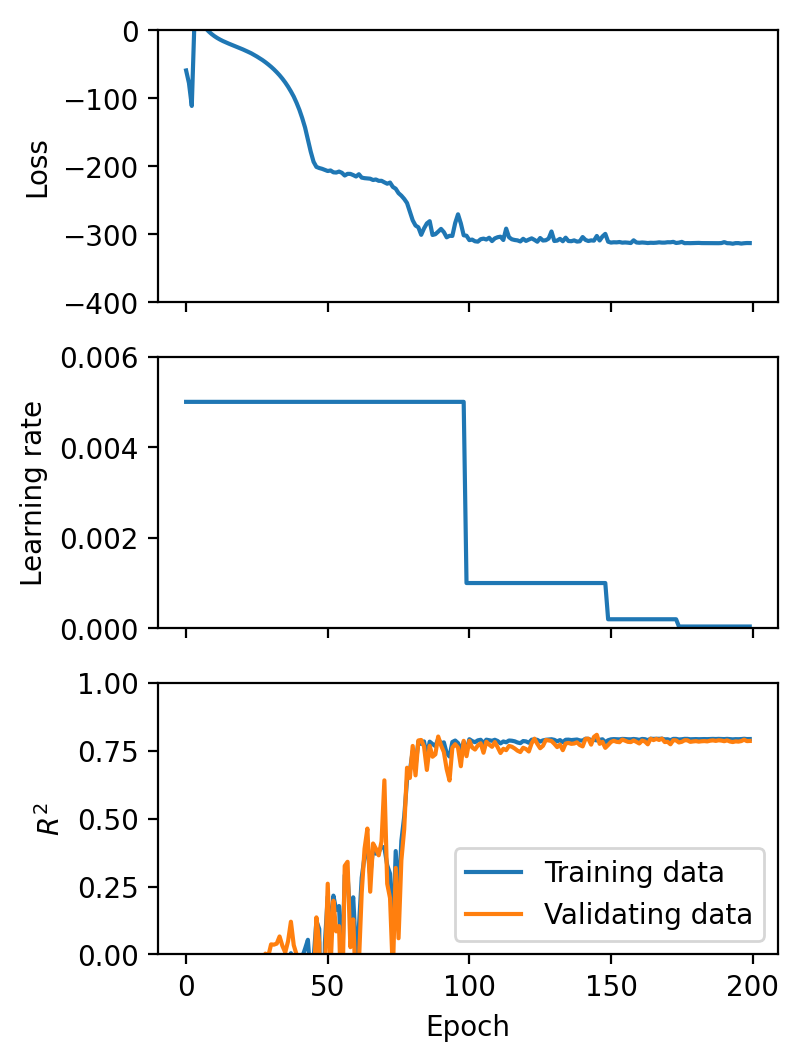

In [7]:
fig, axes = plt.subplots(3,1,sharex=True,figsize=[4,6],dpi=200)
axes[0].plot(log['LLLoss'])
axes[0].set_ylabel('Loss')
axes[0].set_ylim([-400,0])
axes[1].plot(log['lr'])
axes[1].set_ylabel('Learning rate')
axes[1].set_ylim([0,0.006])
axes[2].plot(log['training_score'], label='Training data')
axes[2].plot(log['validating_score'], label='Validating data')
axes[2].set_ylabel(r'$R^2$')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].set_ylim([0,1])

Text(0.5, 1.0, 'Prediction by ANN')

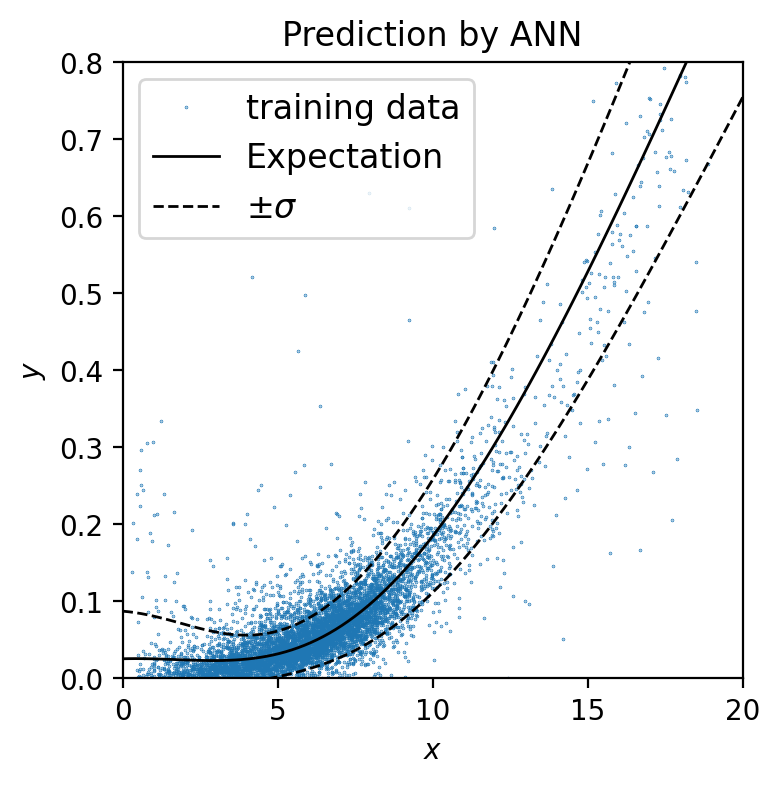

In [11]:
x1_vis = np.linspace(0,20,100)
X_uniform = np.hstack([x1_vis.reshape(-1,1),])
model.X_uniform = torch.tensor(X_uniform.astype('float32'))
mean_uniform, var_uniform = model.evaluate_uniform()


plt.figure(figsize=(4,4), dpi=200)
plt.plot(training_data.X[:], training_data.Y[:], '.', markersize=0.5, label='training data')
plt.plot(model.X_uniform,mean_uniform,'-', lw=1, color='k', label='Expectation')
plt.plot(model.X_uniform,mean_uniform-var_uniform**0.5,'--', lw=1, color='k', label='$\pm \sigma$')
plt.plot(model.X_uniform,mean_uniform+var_uniform**0.5,'--', lw=1, color='k')

plt.xlim([0,20])
plt.xticks([0,5,10,15,20])
plt.ylim([0,0.8])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left', fontsize=12)
plt.title('Prediction by ANN' )